## Chargement et Prétraitement du Dataset

### Chargement des images du dataset et vérification des extensions (jpeg, jpg, bmp, png)

In [108]:
import os, cv2

images_folder = './Data'

valid_extensions = ['.jpeg', '.jpg', '.bmp', '.png']

non_valid_extensions = []

for subfolder in os.listdir(images_folder):
    subfolder_path = os.path.join(images_folder,subfolder)

    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            file_path = os.path.join (subfolder_path, file)
            _,extension = os.path.splitext(file_path)
            extension = extension.lower()

            if os.path.isfile(file_path) and extension not in valid_extensions:
                print(f"Suppression de: {file_path}")
                os.remove(file_path)

### Mélange des images de toutes les classes dans deux listes

In [109]:
import random

images = []
labels = []

for class_name in os.listdir(images_folder):
    folder_path = os.path.join(images_folder, class_name)

    if os.path.isdir(folder_path):

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)

            if os.path.isfile(file_path):
                images.append(file_path)
                labels.append(class_name)

combined = list(zip(images,labels))
random.shuffle(combined)

images_shuffled, labels_shuffled = zip(*combined)

images_shuffled = list(images_shuffled)
labels_shuffled = list(labels_shuffled)


### Redimensionnement des images

In [110]:
for i in range(len(images_shuffled)):
    try:
        images_shuffled[i] = cv2.imread(images_shuffled[i])
        images_shuffled[i] = cv2.resize(images_shuffled[i], (224,224))
    except Exception as e:
        print(f"Erreur: {e}")

### Conversion des images en tableaux NumPy

In [111]:
import numpy as np

images_np = np.array(images_shuffled)
labels_np = np.array(labels_shuffled)

### Affichage graphique du nombre d’images dans chaque classe

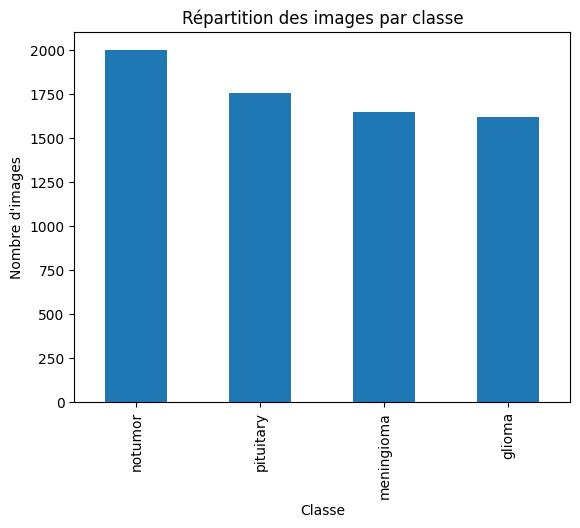

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'label': labels_np})
df['label'].value_counts().plot(kind='bar')
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe")
plt.show()

### Aperçu d’images pour chaque classe

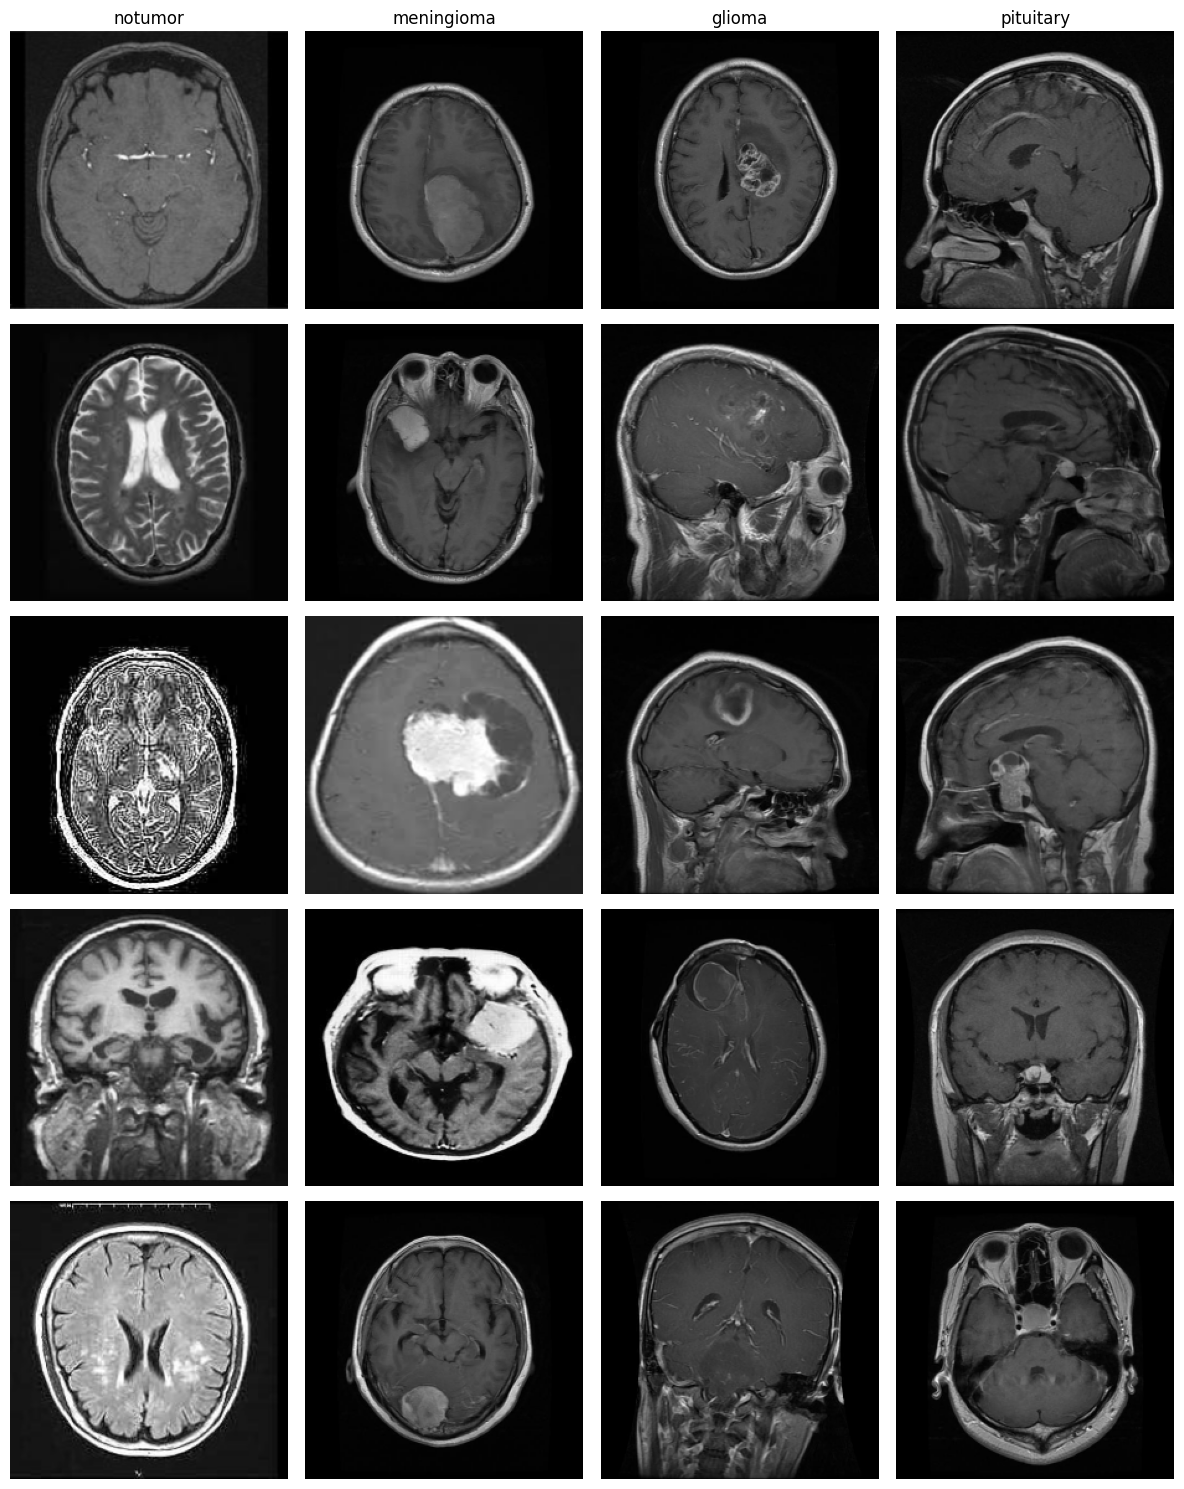

In [113]:
classes = list(set(labels_np))
fig, axes = plt.subplots(5, len(classes), figsize=(3*len(classes), 15))

for i, class_name in enumerate(classes):
    class_images = [img for img, label in zip(images_np, labels_np) if label == class_name]
    
    for j in range(5):
        if j < len(class_images):
            axes[j, i].imshow(class_images[j])
            if j == 0:
                axes[j, i].set_title(class_name)
            axes[j, i].axis('off')
plt.tight_layout()
plt.show()

### Vérifier l’équilibre entre les classes

In [114]:
from collections import Counter

class_counts = Counter(labels_np)

print("Nombre d'images par classe :")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Nombre d'images par classe :
pituitary: 1757
notumor: 2000
meningioma: 1645
glioma: 1621


### Application de rééquilibrage

In [115]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

for class_name in ['glioma', 'meningioma', 'pituitary']:
    class_imgs = [images_shuffled[i] for i, label in enumerate(labels_shuffled) if label == class_name]
    needed = 2000 - len(class_imgs)
    
    for i in range(needed):
        img = class_imgs[i % len(class_imgs)]
        aug_img = datagen.random_transform(img)
        images_shuffled.append(aug_img.astype('uint8'))
        labels_shuffled.append(class_name)

combined = list(zip(images_shuffled, labels_shuffled))
random.shuffle(combined)
images_shuffled, labels_shuffled = zip(*combined)
images_shuffled = list(images_shuffled)
labels_shuffled = list(labels_shuffled)

images_np = np.array(images_shuffled)
labels_np = np.array(labels_shuffled)


print("\nFinal counts:")
print(Counter(labels_shuffled))


Final counts:
Counter({'glioma': 2000, 'pituitary': 2000, 'notumor': 2000, 'meningioma': 2000})


### Transformation les étiquettes textuelles en format numérique

In [116]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()

integer_labels = encoder.fit_transform(labels_np)

one_hot_labels = to_categorical(integer_labels)


### Division des données en ensembles d’entraînement et de test

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_np, one_hot_labels, test_size=0.2, random_state=42)

type(y_test)

numpy.ndarray

### Normalisation des valeurs des pixels dans la plage [0, 1]

In [118]:
X_train = X_train/255.0
X_test = X_test/255.0

### Définition de l’architecture CNN

In [168]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout 

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=3, activation ='relu', input_shape=(224,224,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=32, kernel_size=3, activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=3, activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

### Vérification de l’architecture du modèle

In [169]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 32)             │     1,384,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,252 (5.39 MB)

 Trainable params: 1,413,252 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation du modèle

In [170]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Entraînement du modèle

In [171]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath='best_model(1).h5',       
    monitor='val_accuracy',               
    save_best_only=True,                
    mode='max',                         
    verbose=1                           
)

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,             
    mode='max',     
    verbose=1,
    restore_best_weights=True
)

start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

end_time = time.time()

duration = end_time - start_time

print(f"Durée d'entraînement : {duration} secondes")

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5690 - loss: 0.9704
Epoch 1: val_accuracy improved from None to 0.77969, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - accuracy: 0.6799 - loss: 0.7646 - val_accuracy: 0.7797 - val_loss: 0.5372
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8102 - loss: 0.4810
Epoch 2: val_accuracy improved from 0.77969 to 0.85000, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - accuracy: 0.8201 - loss: 0.4508 - val_accuracy: 0.8500 - val_loss: 0.3849
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8855 - loss: 0.3081
Epoch 3: val_accuracy improved from 0.85000 to 0.86406, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.8822 - loss: 0.3061 - val_accuracy: 0.8641 - val_loss: 0.3422
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9200 - loss: 0.2129
Epoch 4: val_accuracy improved from 0.86406 to 0.88203, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.9143 - loss: 0.2139 - val_accuracy: 0.8820 - val_loss: 0.3124
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9504 - loss: 0.1376
Epoch 5: val_accuracy improved from 0.88203 to 0.88750, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9484 - loss: 0.1443 - val_accuracy: 0.8875 - val_loss: 0.3188
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9701 - loss: 0.0954
Epoch 6: val_accuracy improved from 0.88750 to 0.91094, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.9676 - loss: 0.0987 - val_accuracy: 0.9109 - val_loss: 0.2929
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9806 - loss: 0.0593
Epoch 7: val_accuracy did not improve from 0.91094
160/160 ━━━━━━━━━━━━━━━━━━━━ 33s 206ms/step - accuracy: 0.9773 - loss: 0.0683 - val_accuracy: 0.8961 - val_loss: 0.3741
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9699 - loss: 0.0851
Epoch 8: val_accuracy improved from 0.91094 to 0.91172, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9752 - loss: 0.0750 - val_accuracy: 0.9117 - val_loss: 0.2802
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9838 - loss: 0.0469
Epoch 9: val_accuracy did not improve from 0.91172
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9838 - loss: 0.0449 - val_accuracy: 0.9062 - val_loss: 0.3605
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9853 - loss: 0.0418
Epoch 10: val_accuracy did not improve from 0.91172
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9850 - loss: 0.0411 - val_accuracy: 0.9031 - val_loss: 0.3775
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9811 - loss: 0.0619
Epoch 11: val_accuracy improved from 0.91172 to 0.91562, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9863 - loss: 0.0457 - val_accuracy: 0.9156 - val_loss: 0.4018
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9878 - loss: 0.0356
Epoch 12: val_accuracy did not improve from 0.91562
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9836 - loss: 0.0471 - val_accuracy: 0.9133 - val_loss: 0.3245
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9867 - loss: 0.0411
Epoch 13: val_accuracy improved from 0.91562 to 0.92031, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.9871 - loss: 0.0385 - val_accuracy: 0.9203 - val_loss: 0.3178
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9948 - loss: 0.0192
Epoch 14: val_accuracy improved from 0.92031 to 0.92266, saving model to best_model(1).h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9941 - loss: 0.0200 - val_accuracy: 0.9227 - val_loss: 0.3715
Epoch 15/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9922 - loss: 0.0259
Epoch 15: val_accuracy did not improve from 0.92266
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9934 - loss: 0.0209 - val_accuracy: 0.9180 - val_loss: 0.3946
Epoch 16/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9910 - loss: 0.0267
Epoch 16: val_accuracy did not improve from 0.92266
160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9902 - loss: 0.0303 - val_accuracy: 0.9086 - val_loss: 0.4139
Epoch 17/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9957 - loss: 0.0167
Epoch 17: val_accuracy did not improve from 0.92266
160/160 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9928 - loss: 0.0233 - val_accuracy: 0.9102 - val_loss: 0.4131
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 14.
Durée d'entr

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model(1).h5')

test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9087 - loss: 0.4876


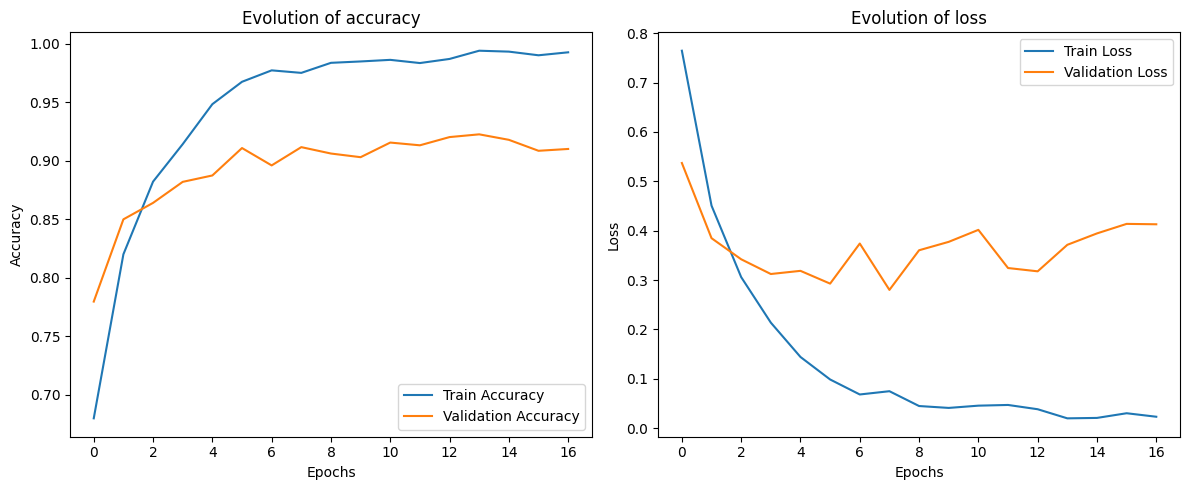

In [178]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Evolution of accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Evolution of loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report :
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       399
           1       0.85      0.85      0.85       413
           2       0.97      0.96      0.97       404
           3       0.92      0.95      0.93       384

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



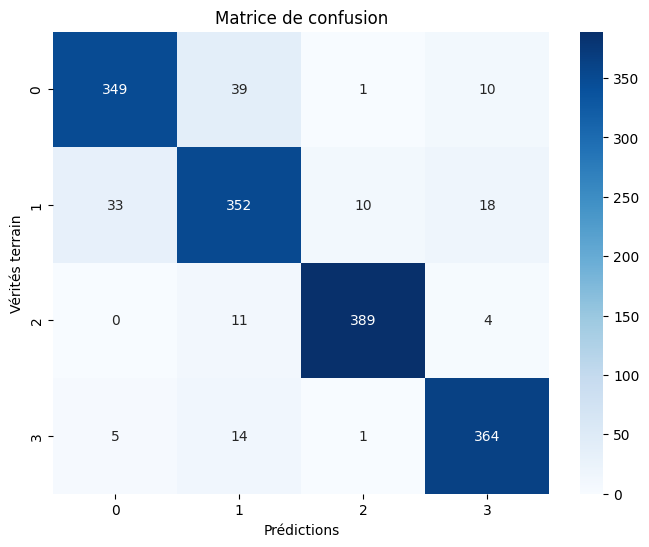

In [179]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = best_model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Classification Report :")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.show()


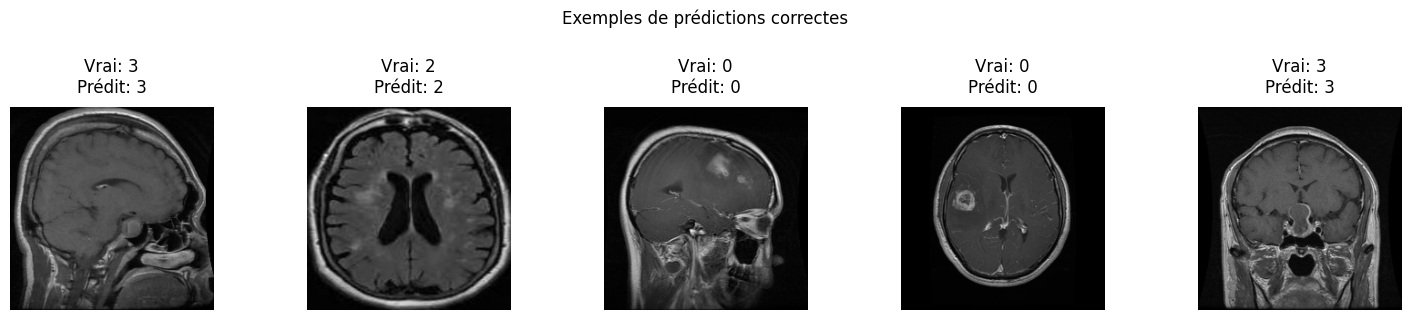

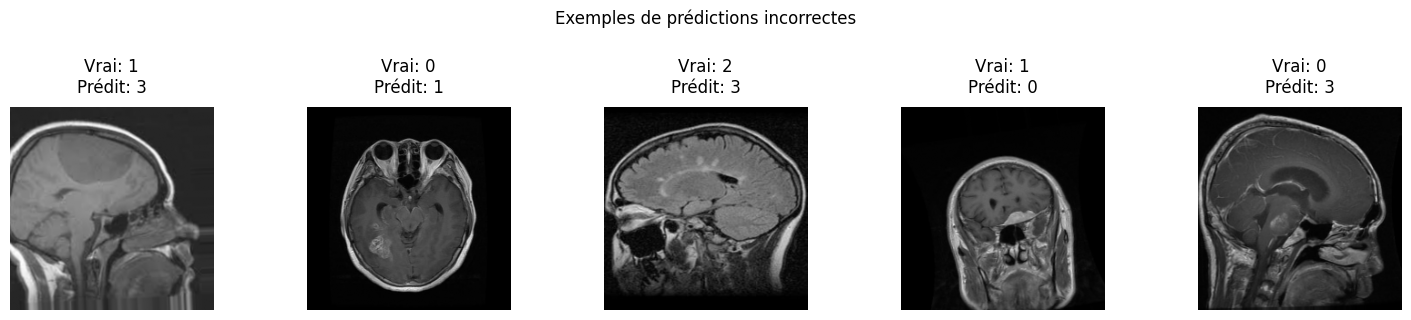

In [ ]:
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]


num_examples = 5


def plot_examples(indices, title):
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices[:num_examples]):
        plt.subplot(1, num_examples, i + 1)
        
        if X_test.shape[-1] == 1:
            plt.imshow(X_test[idx].squeeze(), cmap='gray')
        else:
            plt.imshow(X_test[idx])
        plt.title(f"Vrai: {y_true[idx]}\nPrédit: {y_pred[idx]}", pad=10)
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()


plot_examples(correct_indices, "Exemples de prédictions correctes")


plot_examples(incorrect_indices, "Exemples de prédictions incorrectes")

<>:69: SyntaxWarning: invalid escape sequence '\D'
<>:69: SyntaxWarning: invalid escape sequence '\D'
C:\Users\moham\AppData\Local\Temp\ipykernel_22564\2255785759.py:69: SyntaxWarning: invalid escape sequence '\D'
  predicted_class, probabilities, image = predict_image('.\Data\glioma\Te-gl_0010.jpg')



Image: .\Data\glioma\Te-gl_0010.jpg

Classe prédite: GLIOMA
Confiance: 100.00%

Probabilités pour chaque classe:
  glioma      : 100.00%
  meningioma  : 0.00%
  notumor     : 0.00%
  pituitary   : 0.00%



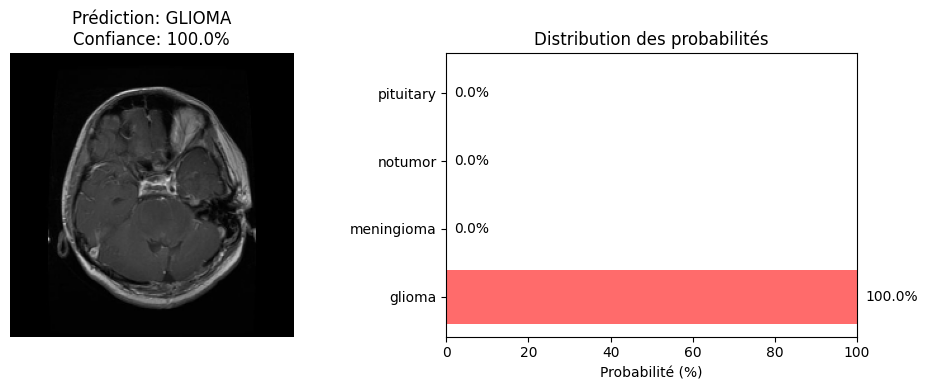

In [186]:
def predict_image(path, model_path='best_model(1).h5'):

    model = load_model(model_path)
    

    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    try:
        
        img = cv2.imread(path)
        
        if img is None:
            raise ValueError(f"Impossible de charger l'image: {path}")
        
       
        img_resized = cv2.resize(img, (224, 224))
        
       
        img_normalized = img_resized / 255.0
        
        img_batch = np.expand_dims(img_normalized, axis=0)
        
    
        predictions = model.predict(img_batch, verbose=0)
        
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[0][predicted_class_idx]
        
        print(f"\n{'='*50}")
        print(f"Image: {path}")
        print(f"{'='*50}")
        print(f"\nClasse prédite: {predicted_class.upper()}")
        print(f"Confiance: {confidence*100:.2f}%")
        print(f"\nProbabilités pour chaque classe:")
        for i, class_name in enumerate(class_names):
            print(f"  {class_name:12s}: {predictions[0][i]*100:.2f}%")
        print(f"{'='*50}\n")
        
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(f"Prédiction: {predicted_class.upper()}\nConfiance: {confidence*100:.1f}%")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        colors = ['#ff6b6b' if i == predicted_class_idx else '#4ecdc4' 
                  for i in range(len(class_names))]
        plt.barh(class_names, predictions[0] * 100, color=colors)
        plt.xlabel('Probabilité (%)')
        plt.title('Distribution des probabilités')
        plt.xlim(0, 100)
        
        for i, v in enumerate(predictions[0] * 100):
            plt.text(v + 2, i, f'{v:.1f}%', va='center')
        
        plt.tight_layout()
        plt.show()
        
        return predicted_class, predictions[0], img_rgb
        
    except Exception as e:
        print(f"Erreur lors de la prédiction: {e}")
        return None, None, None


predicted_class, probabilities, image = predict_image('.\Data\glioma\Te-gl_0010.jpg')

In [187]:
import pickle
pickle.dump(history.history, open('history.pkl', 'wb'))